Студент Жилкин Федор, 344
# Домашняя работа 5: "Решение краевой задачи для ОДУ второго порядка."
**Задания:**
1. Разностный метод
2. Метод разностной прогонки

$$- \frac{7-x}{8+3x}u^{''}+(1+ \frac{x}{3})u^{'}+(1-\frac{1}{2}e^{\frac{x}{2}})u= \frac{1}{2} - \frac{x}{3}, u(-1)=u(1)=0$$

In [3]:
import numpy as np
import pandas as pd 
import sympy
import matplotlib.pyplot as plt 
from scipy import interpolate

$-p(x)u" + q(x)u' + r(x)u = f(x), y(a) = \alpha, y(b) = \beta$ 

In [4]:
def f(x):
    return 1/2 - x/3

def r(x):
    return 1 - 1/2*np.exp(x/2)

def q(x):
    return 1 + x/3

def p(x):
    return (7 - x)/(8 + 3*x)

In [5]:
a, b = -1, 1
alpha = beta = 0

## Разностный метод

Вычисляем коэффициенты для уравнения вида: $$A_iy_{i-1} - B_iy_i + C_iy_{i+1} = G_i$$

In [6]:
def coeffs(h, x):
    
    """
    Вычисляем коэффициенты A, B, C, G
    x -- точка 
    """
    
    A = (-p(x) / h**2) + (-q(x) / 2*h)
    B = -(2*p(x) / h**2 + r(x))
    C = (-p(x) / h**2) + (q(x) / 2*h)
    G = f(x)
    
    return A, B, C, G

Т.к. получаем решение для **свдинутой сетки**, то выполним **интерполирование** для получение значений на основной сетке.

In [8]:
def interpolation(x, y):
    """
    Интерполируем по узлам сдвинутой сетки, чтобы получить значения в точках
    основной сетки.
    x -- точки
    y -- значения в точках
    """
    return interpolate.interp1d(x, y)

In [109]:
def difference_method(n):
    
    """
    Решение уравнения разностным методом.
    Аппроксимировать граничные условия будем с порядком O(h^2) 
    n -- кол-во частей в разбиении отрезка
    """
    
    h = (b - a) / n
    x_main = np.arange(a, b + h, h) # Основная сетка, n+1 точка
    x_shifted = np.arange(a - h/2, b + h, h) # Сдвинутая сетка, n+2 точки
    
    M = np.zeros((n+2, n+2)) # Матрица коэффициентов
    for i in range(1, n+1):
        A, B, C, G = coeffs(h, x_shifted[i])
        M[i][i-1] = A
        M[i][i] = -B
        M[i][i+1] = C
    
    # Первый ряд
    B, C = coeffs(h, x_shifted[0])[1], coeffs(h, x_shifted[0])[2]
    M[0][0] = B
    M[0][1] = C
    
    # Последний ряд
    A, B = coeffs(h, x_shifted[n+1])[0], coeffs(h, x_shifted[n+1])[1]
    M[n+1][n+1] = B
    M[n+1][n] = A
    
    # Столбец справа
    G = f(x_shifted)

    # Ответ
    Y = np.linalg.solve(M, G)
    
    return Y, x_shifted

## Тестирование разностного метода

1. Решим уравнение на сдвинутой сетки
2. Произведем интерполирование и найдем значение в точках основной сетки
3. Разобьем сетку с шагом $h/2$ и выполним п. 1 и п.2 
4. Уточним решение по Ричардсону
5. Сравним полученные результаты с **точным решением**

In [110]:
def test_difference(n):
    
    """
    Тестирование разностного метода.
    n -- кол-во частей в разбиении отрезка.
    """
    
    # Добавляем граничные точки
    def add_boundaries(X, Y):
        X = np.insert(X, 1, -1)
        Y = np.insert(Y, 1, 0)
        X = np.insert(X, -1, -1)
        Y = np.insert(Y, -1, 0)
        return X, Y
    
    # Уточнение по Ричардсону
    def richardson(y1, y2, s=2):
        y_rev = []
        for i in range(len(y1)):
            r_m = (y2[2*i] - y1[i]) / (pow(2, s) - 1)
            y_rev.append(y2[2*i] + r_m)
        return y_rev
    
    h = (b - a) / n
    Y, X = difference_method(n)
    X, Y = add_boundaries(X, Y)
    
    # Интерполируем
    inter = interpolation(X, Y)
    x = np.arange(a, b + h, h)
    y = np.array([inter(i) for i in x]) # Ответ
    
    # Решение с разбиением h/2 для уточнения по Ричардсону
    h = (b - a) / (2*n)
    Y_h, X_h = difference_method(2*n)
    X_h, Y_h = add_boundaries(X_h, Y_h)
    
    # Интерполируем
    inter_2 = interpolation(X_h, Y_h)
    x_h = np.arange(a, b + h, h)
    y_h = np.array([inter_2(i) for i in x_h]) 
    
    # Ответ, уточненный по Ричардсону
    y_ut = richardson(y, y_h)
    
    # Точное решение (получено с помощью сервиса WolframAlpha)
    # Методому Рунге-Кутта четвертого порядка
    y_ex = [0, 0.0733, 0.1330, 0.1795, 0.2130, 0.2330, 0.2383, 0.2262, 0.1911, 0.1224, 0]
    
    # Погрешность ответов
    error_y = [abs(a-b) for a, b in zip(y, y_ex)]
    error_y_ut = [abs(a-b) for a, b in zip(y_ut, y_ex)]
    
    return x, y, y_ut, error_y, error_y_ut

In [111]:
x, y, y_ut, error_y, error_y_ut = test_difference(10)

data = {
    "$$x$$" : x,
    "$$Y$$" : y,
    "$$Y_{ut}$$" : y_ut,
    "$$Y - Y_{ex}$$" : error_y,
    "$$Y_{ut} - Y_{ex}$$" : error_y_ut
       }

pd.DataFrame(data).round(3)

,$$x$$,$$Y$$,$$Y_{ut}$$,$$Y - Y_{ex}$$,$$Y_{ut} - Y_{ex}$$
0,-1.0,0.000,0.000,0.000,0.000
1,-0.8,0.092,0.089,0.019,0.015
2,-0.6,0.155,0.152,0.022,0.019
3,-0.4,0.198,0.195,0.019,0.016
4,-0.2,0.223,0.220,0.010,0.007
5,-0.0,0.230,0.226,0.003,0.007
6,0.2,0.219,0.214,0.019,0.024
7,0.4,0.192,0.185,0.035,0.041
8,0.6,0.147,0.140,0.044,0.051
9,0.8,0.086,0.079,0.036,0.043


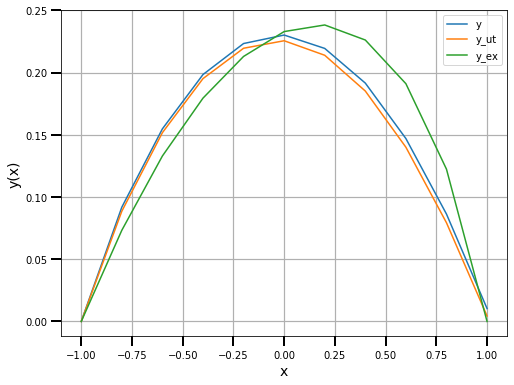

In [112]:
x, y, y_ut, _, _ = test_difference(10)
y_ex = [0, 0.0733, 0.1330, 0.1795, 0.2130, 0.2330, 0.2383, 0.2262, 0.1911, 0.1224, 0]

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel("x", fontsize=14)        
ax.set_ylabel("y(x)", fontsize=14)
ax.grid(which="major", linewidth=1.2)
ax.grid(which="minor", linestyle="--", color="gray", linewidth=0.5)
ax.plot(x, y, label="y")
ax.plot(x, y_ut, label="y_ut")
ax.plot(x, y_ex, label="y_ex")
ax.legend()

ax.xaxis.set_minor_locator(plt.AutoLocator())
ax.yaxis.set_minor_locator(plt.AutoLocator())

ax.tick_params(which='major', length=10, width=2)
ax.tick_params(which='minor', length=5, width=1)
plt.show()

Решение $Y_{ex}$ было получено с помощью **метода Рунге-Кутта четвертого порядка**, т.е. оно тоже является **приближенным**. Оно приведено только лишь для сравнения с нашими результатами.